In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import datetime
import tensorflow as tf

In [2]:
imageHeight = 224
imageWidth = 224

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib
base_dir = pathlib.Path("chest_xray")

# base_dir = '/aiffel/aiffel/mq2/chest_xray'
train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(imageHeight, imageWidth),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir / "val",
    image_size=(imageHeight, imageWidth),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(imageHeight, imageWidth),
    batch_size=32)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [4]:
#데이터 증식
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.01),
        layers.RandomZoom(0.2),
    ]
)

In [5]:
#vgg16 모델
img_input = layers.Input(shape=(imageHeight, imageWidth, 3))
# 데이터 증강
x = data_augmentation(img_input)
x = layers.Rescaling(1./255)(x)#0~1값으로 정규화
# Block 1
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(img_input)
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv1')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv2')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv1')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv2')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
# Classification block
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512, activation='relu', name='fc1')(x)
x = layers.Dropout(0.4)(x)#드롭아웃 추가
x = layers.Dense(128, activation='relu', name='fc2')(x)
x = layers.Dropout(0.2)(x)#드롭아웃 추가
#2진분류이므로 활설화함수 sigmoid로 변경
x = layers.Dense(1, activation='sigmoid', name='predictions')(x)
model_vgg16 = keras.Model(img_input, x, name='vgg16')

In [6]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
model_vgg16.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [8]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="vgg16.keras",
      save_best_only=True,
      
    monitor="val_loss",
    patience=5),
    keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
    ,
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5
    )
]


In [9]:
history = model_vgg16.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
163/163 [==============================] - 89s 399ms/step - loss: 4.9731 - accuracy: 0.7316 - val_loss: 0.6134 - val_accuracy: 0.7500
Epoch 2/30
163/163 [==============================] - 67s 395ms/step - loss: 0.3920 - accuracy: 0.8177 - val_loss: 0.5852 - val_accuracy: 0.8750
Epoch 3/30
163/163 [==============================] - 65s 393ms/step - loss: 0.4040 - accuracy: 0.8426 - val_loss: 1.0565 - val_accuracy: 0.7500
Epoch 4/30
163/163 [==============================] - 64s 389ms/step - loss: 0.3632 - accuracy: 0.8512 - val_loss: 0.5556 - val_accuracy: 0.8750
Epoch 5/30
163/163 [==============================] - 64s 390ms/step - loss: 0.3953 - accuracy: 0.8447 - val_loss: 0.5497 - val_accuracy: 0.8125
Epoch 6/30
163/163 [==============================] - 64s 390ms/step - loss: 0.3336 - accuracy: 0.8608 - val_loss: 0.5988 - val_accuracy: 0.8750
Epoch 7/30
163/163 [==============================] - 64s 390ms/step - loss: 0.3159 - accuracy: 0.8679 - val_loss: 0.7520 - val_ac

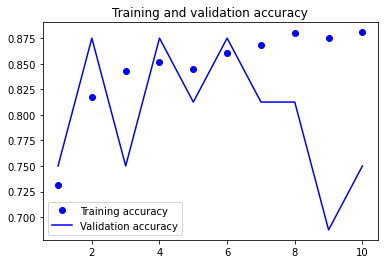

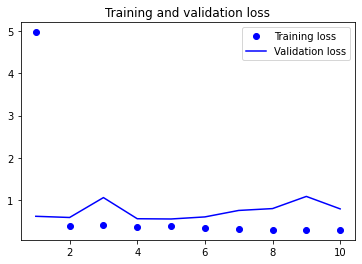

In [10]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [11]:
test_model = keras.models.load_model(
    "vgg16.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

20/20 [==============================] - 5s 132ms/step - loss: 0.6673 - accuracy: 0.7196
테스트 정확도: 0.720


# CAM

In [12]:
test_model = keras.models.load_model(
    "vgg16.keras")

In [13]:
import numpy as np

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
#     array = keras.applications.xception.preprocess_input(array)
    return array
img_path ='/aiffel/aiffel/mq2/chest_xray/test/PNEUMONIA/person96_bacteria_465.jpeg'
# img = keras.utils.load_img(img_path, target_size=(imageHeight, imageWidth))
# image = tf.io.read_file(img_path)

# # 이미지를 Tensor로 변환
# image = tf.image.decode_image(image, channels=3)
# image = tf.image.resize(image, [imageHeight, imageWidth])
image = get_img_array(img_path,(imageHeight, imageWidth))

In [14]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "flatten",
    "fc1",
    "dropout",
    "fc2",
    "dropout_1",
    "predictions"
]
last_conv_layer = test_model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(test_model.inputs, last_conv_layer.output)

In [15]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = test_model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [16]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [17]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

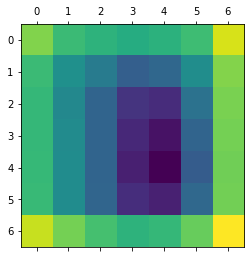

In [18]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [19]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

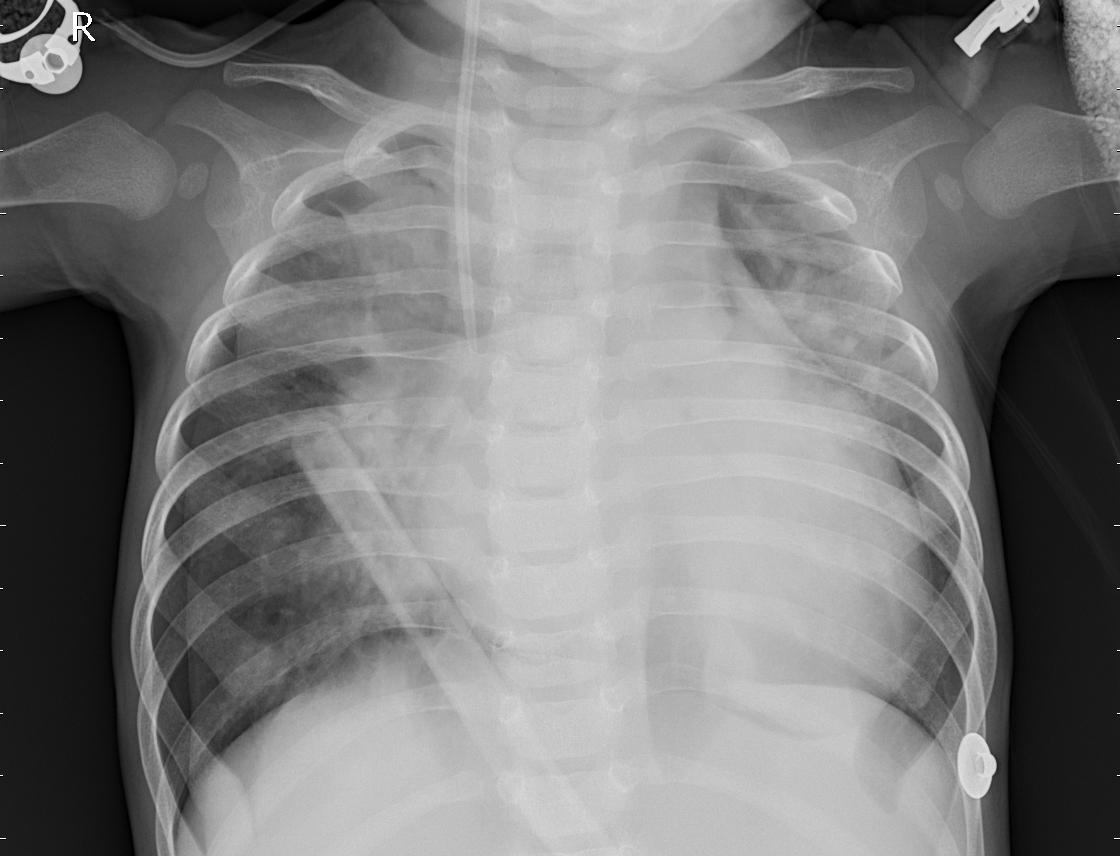

In [20]:
from IPython.display import Image
Image(img_path)
# Image("elephant_cam.jpg")


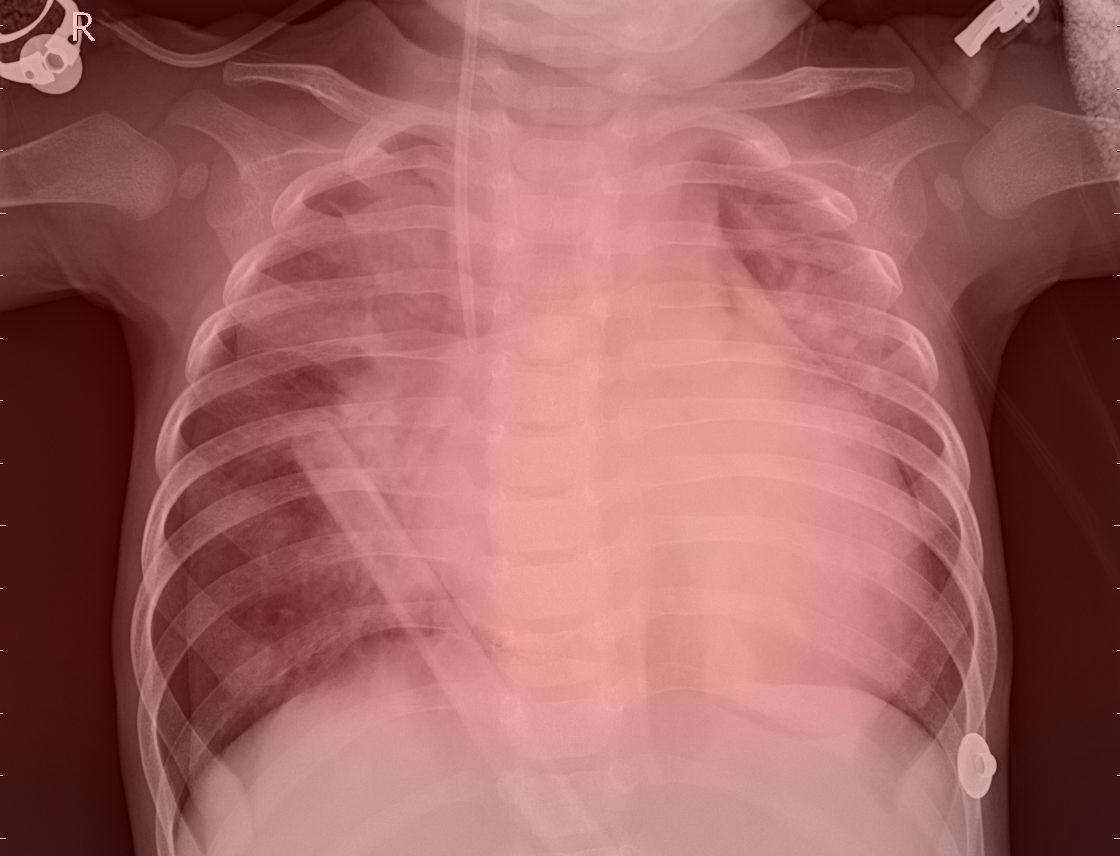

In [21]:
Image("elephant_cam.jpg")